In [1]:
import csv
import os
import timeit

import numpy as np

import skimage
from skimage.morphology import skeletonize
from skimage.filters import threshold_local, threshold_mean, threshold_minimum

import cv2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from utils.process import read_in_mnist

In [2]:
mnist_filename = '../data/mnist/mnist_test.csv'
mnist_images_raw, mnist_labels = read_in_mnist(mnist_filename)


In [3]:
print(len(mnist_images_raw))
print(len(mnist_labels))


10000
10000


In [4]:
# this list is length 18
interesting_examples_list = [1061, 1438, 1762, 1775, 2649, 3266,
                            3624, 3864, 3894, 4923, 5108, 5847, 
                             6344, 6428, 8493, 8865, 8951, 9688]

# this list is length 14
complex_examples_list = [620, 1411, 2023, 2358, 2638, 
                         3073, 3450, 3646, 4611, 4759,
                        5593, 7536, 9508, 9948]

combined_examples_list = interesting_examples_list + complex_examples_list

# this is our number 8 case study
combined_examples_list += [3406]


In [5]:
# choose image
idx = 1061
label = mnist_labels[idx]
image = mnist_images_raw[idx]


## Calculating binaries

In [6]:
def get_binaries(img):
    """
    Returns image binaries based on different methods from
    OpenCV, skimage, and the minimum threshold histogram method.
    """
    #convert to binary using four different techniques
    # opencv
    ret, binaryCV = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
    binaryCV = np.pad(binaryCV, 1) / 255

    # opencv adaptive
    # the last two values are the Num x Num area (odd number) to run the thresholding on, and 
    # a value to subtract from the mean value 
    block_size = 7
    offset = 0
    binaryCV_adapt = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY, block_size, offset)
    binaryCV_adapt = np.pad(binaryCV_adapt, 1) / 255

    # skimage
    binarySK = img > threshold_mean(img)
    binarySK = np.pad(binarySK, 1)

    # skimage adaptive
    # try to use the same values you used for cv2.adaptiveThreshold()
    binarySK_adapt = img > threshold_local(img, block_size, "gaussian", offset)
    binarySK_adapt = np.pad(binarySK_adapt, 1)

    # histogram method
    # background pixels have a value = 0
    histogram_threshold = threshold_minimum(img)
    binaryHST = img > histogram_threshold
    binaryHST = np.pad(binaryHST, 1)
    
    return [binaryCV, binaryCV_adapt, binarySK, binarySK_adapt, binaryHST]


In [7]:
binaries_list = get_binaries(image)
binaryCV, binaryCV_adapt, binarySK, binarySK_adapt, binaryHST = binaries_list


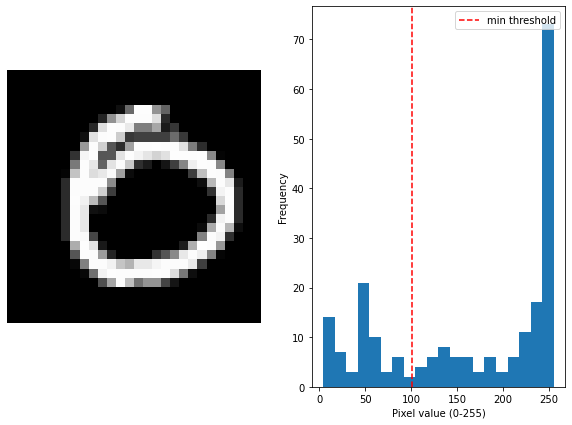

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(image, cmap="gray")

# compare these two lines
histogram_threshold = threshold_minimum(image)
ax[1].hist([val for val in image.flatten() if val != 0], bins=20)
ax[1].axvline(histogram_threshold, color='r', linestyle="--", label="min threshold")

ax[0].axis('off')
ax[1].set_xlabel("Pixel value (0-255)")
ax[1].set_ylabel("Frequency")

ax[1].legend(loc="upper right")

plt.show()


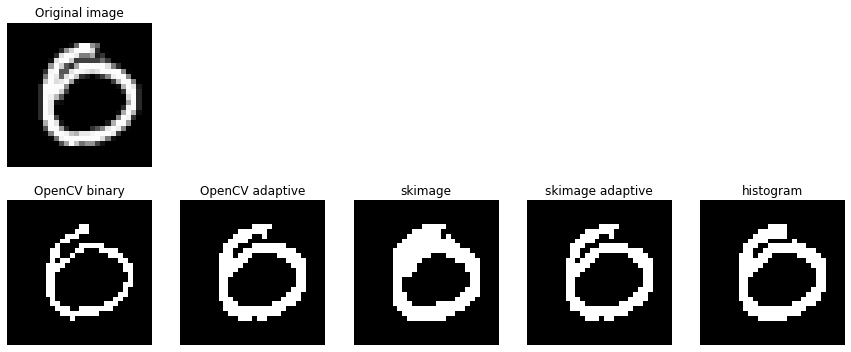

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

ax[0, 0].imshow(image, cmap="gray")

ax[1, 0].imshow(binaryCV, cmap="gray")
ax[1, 1].imshow(binaryCV_adapt, cmap="gray")
ax[1, 2].imshow(binarySK, cmap="gray")
ax[1, 3].imshow(binarySK_adapt, cmap="gray")
ax[1, 4].imshow(binaryHST, cmap="gray")

ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[0, 3].axis('off')
ax[0, 4].axis('off')

ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')
ax[1, 3].axis('off')
ax[1, 4].axis('off')

ax[0, 0].set_title('Original image')
ax[1, 0].set_title('OpenCV binary')
ax[1, 1].set_title('OpenCV adaptive')
ax[1, 2].set_title('skimage')
ax[1, 3].set_title('skimage adaptive')
ax[1, 4].set_title('histogram')

plt.show()


## Calculating skeletons

In [10]:
def neighbours(x, y, image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9


In [11]:
def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)


In [12]:
def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned


In [13]:
def plot_skeleton_comparisons(img, binaries_list, label, idx, save_fig=False, save_dir="./"):
    
    binaryCV, binaryCV_adapt, binarySK, binarySK_adapt, binaryHST = binaries_list
    
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))

    ax[0, 0].imshow(img, cmap="gray")

    # skimage skeletonize()
    ax[1, 0].imshow(skeletonize(binaryCV), cmap="gray")
    ax[1, 1].imshow(skeletonize(binaryCV_adapt), cmap="gray")
    ax[1, 2].imshow(skeletonize(binarySK), cmap="gray")
    ax[1, 3].imshow(skeletonize(binarySK_adapt), cmap="gray")
    ax[1, 4].imshow(skeletonize(binaryHST), cmap="gray")

    # skimage skeltonize(method='lee')
    ax[2, 0].imshow(skeletonize(binaryCV, method="lee"), cmap="gray")
    ax[2, 1].imshow(skeletonize(binaryCV_adapt, method="lee"), cmap="gray")
    ax[2, 2].imshow(skeletonize(binarySK, method="lee"), cmap="gray")
    ax[2, 3].imshow(skeletonize(binarySK_adapt, method="lee"), cmap="gray")
    ax[2, 4].imshow(skeletonize(binaryHST, method="lee"), cmap="gray")

    # skimage skeletonize(method='zhang')
    ax[3, 0].imshow(skeletonize(binaryCV, method="zhang"), cmap="gray")
    ax[3, 1].imshow(skeletonize(binaryCV_adapt, method="zhang"), cmap="gray")
    ax[3, 2].imshow(skeletonize(binarySK, method="zhang"), cmap="gray")
    ax[3, 3].imshow(skeletonize(binarySK_adapt, method="zhang"), cmap="gray")
    ax[3, 4].imshow(skeletonize(binaryHST, method="zhang"), cmap="gray")

    # zhangSuen()
    ax[4, 0].imshow(zhangSuen(binaryCV), cmap="gray")
    ax[4, 1].imshow(zhangSuen(binaryCV_adapt), cmap="gray")
    ax[4, 2].imshow(zhangSuen(binarySK), cmap="gray")
    ax[4, 3].imshow(zhangSuen(binarySK_adapt), cmap="gray")
    ax[4, 4].imshow(zhangSuen(binaryHST), cmap="gray")

    ax[0, 0].axis('off')
    ax[0, 1].axis('off')
    ax[0, 2].axis('off')
    ax[0, 3].axis('off')
    ax[0, 4].axis('off')

    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    ax[1, 1].axis('off')
    ax[1, 2].axis('off')
    ax[1, 3].axis('off')
    ax[1, 4].axis('off')

    ax[2, 0].set_xticks([])
    ax[2, 0].set_yticks([])
    ax[2, 1].axis('off')
    ax[2, 2].axis('off')
    ax[2, 3].axis('off')
    ax[2, 4].axis('off')

    ax[3, 0].set_xticks([])
    ax[3, 0].set_yticks([])
    ax[3, 1].axis('off')
    ax[3, 2].axis('off')
    ax[3, 3].axis('off')
    ax[3, 4].axis('off')

    ax[4, 0].set_xticks([])
    ax[4, 0].set_yticks([])
    ax[4, 1].axis('off')
    ax[4, 2].axis('off')
    ax[4, 3].axis('off')
    ax[4, 4].axis('off')

    ax[1, 0].set_ylabel("skeletonize", fontsize=10)
    ax[2, 0].set_ylabel("skimage - lee", fontsize=10)
    ax[3, 0].set_ylabel("skimage - zhangSuen", fontsize=10)
    ax[4, 0].set_ylabel("zhangSuen", fontsize=10)

    ax[0, 0].set_title('Original image')
    ax[1, 0].set_title('OpenCV')
    ax[1, 1].set_title('OpenCV adaptive')
    ax[1, 2].set_title('skimage')
    ax[1, 3].set_title('skimage adaptive')
    ax[1, 4].set_title('histogram')

    # title, save figure
    figtitle = "skeleton_comparison_{}_idx_{}".format(label, idx)
    fig.suptitle(figtitle, fontsize=14)
    
    if(save_fig is True):
        if not(os.path.isdir(save_dir)):
            os.mkdir(save_dir)
        plt.savefig(save_dir+figtitle+".pdf", bbox_inches='tight', pad_inches = 0, format='pdf')
        #plt.savefig("skeleton_graph.pdf", bbox_inches='tight', format='pdf')     
        # close figure to save on memory if saving many figures at once
        plt.close(fig)
    else:
        fig.tight_layout()
        plt.show()


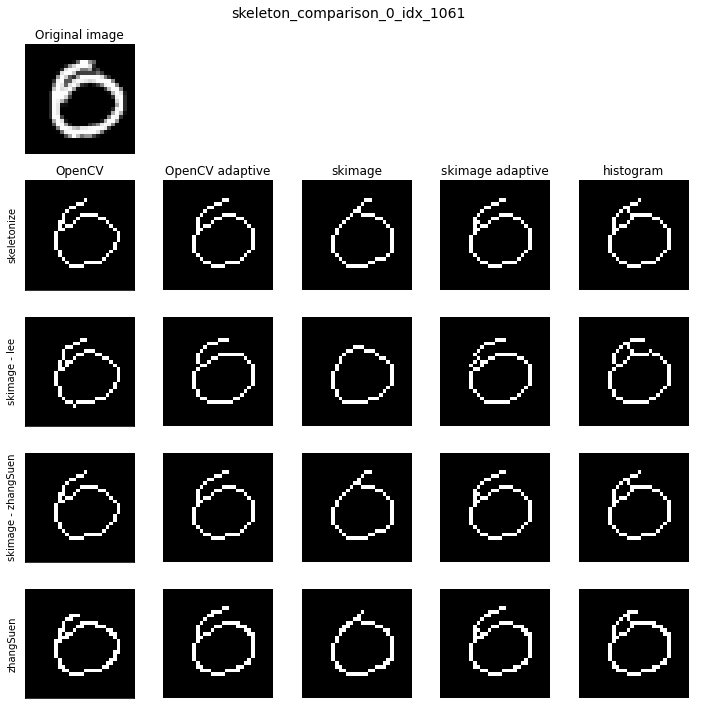

In [14]:
plot_skeleton_comparisons(image, binaries_list, label, idx)


### Comparing thresholding methods on skeleton results

Let's try this again, this time with our example of number 8.

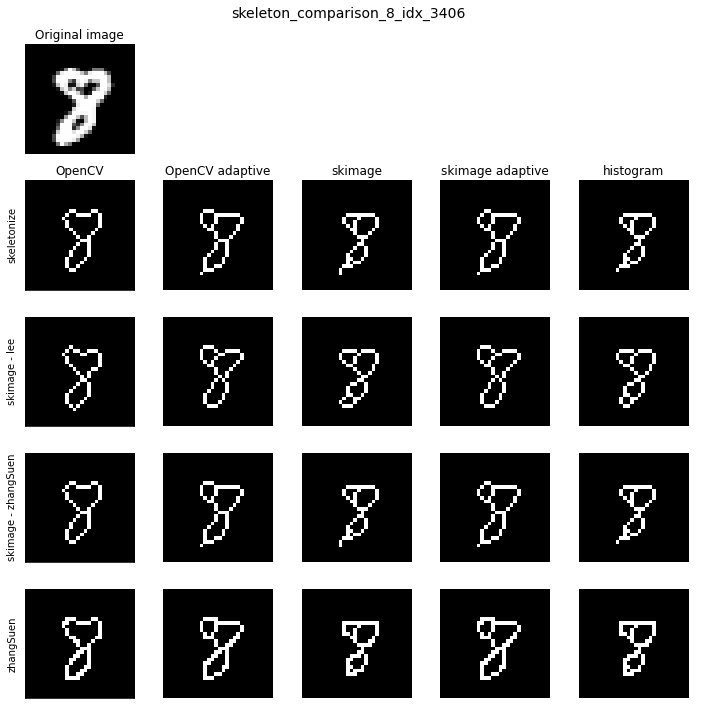

In [15]:
idx = 3406
label = mnist_labels[idx]
image = mnist_images_raw[idx]
binaries_list = get_binaries(image)
plot_skeleton_comparisons(image, binaries_list, label, idx)


And again, with an example that we found complex.

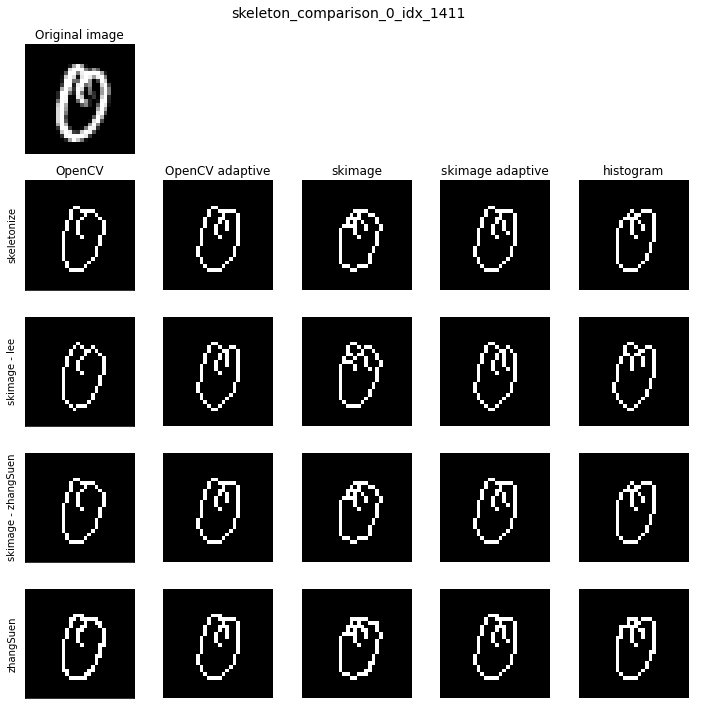

In [16]:
# this was a complex example where binarization/skeletonization method might make a difference
idx = 1411
label = mnist_labels[idx]
image = mnist_images_raw[idx]
binaries_list = get_binaries(image)
plot_skeleton_comparisons(image, binaries_list, label, idx)


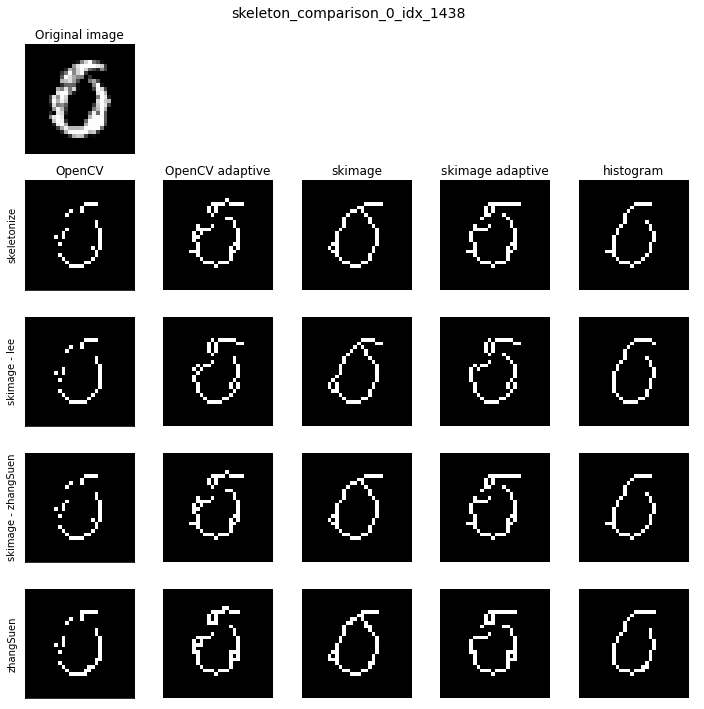

In [17]:
idx = 1438
label = mnist_labels[idx]
image = mnist_images_raw[idx]
binaries_list = get_binaries(image)
plot_skeleton_comparisons(image, binaries_list, label, idx)

A couple interesting things to note:
- The ZhangSuen method from skimage produces slightly different results than our ZhangSuen implementation.
- The adaptive binarization methods from OpenCV and skimage seem to produce mostly the same result (which makes sense, they are trying to do the same thing).
- OpenCV's binary method seems to work just as well, if not better, than the adaptive OpenCV and skimage methods. However, this isn’t always the case (see the example above), but it is hard to know before hand when this will be the case.
- It looks like the best combination is the basic OpenCV binarization method (first column) and skimage's basic skeletonization method or zhangSuen implementation (second and fourth row). However, this changes depending on the image. For example, sometimes the OpenCV methods leave gaps in the skeletons (which we don’t want).

What we really need is a way to combine these binaries in a way that makes them continuous and reduces noise.

In [18]:
# save images for each example in combined_examples_list
# for idx in combined_examples_list:
#     label = mnist_labels[idx]
#     image = mnist_images_raw[idx]
#     binaries_list = get_binaries(image)
#     plot_skeleton_comparisons(image, binaries_list, label, idx, save_fig=True)


## Time test
We can test each binarization and skeletonization method for how much time it takes to run over the full dataset below.